# Google Brain - Ventilator Pressure Prediction
## Summary
This is a Kaggle compatition project by Google Brain. When a patient has trouble breathing, a ventilator is used to pump oxygen into a sedated patient's lungs via a tube in the windpipe. But mechanical ventilation is a clinician-intensive procedure, a limitation that was prominently on display during the early days of the COVID-19 pandemic. The aim of this competition is to simulate a ventilator connected to a sedated patient's lung as an alternative to mechanical ones to predict the time series of pressure. Full description is [here][1].

<center>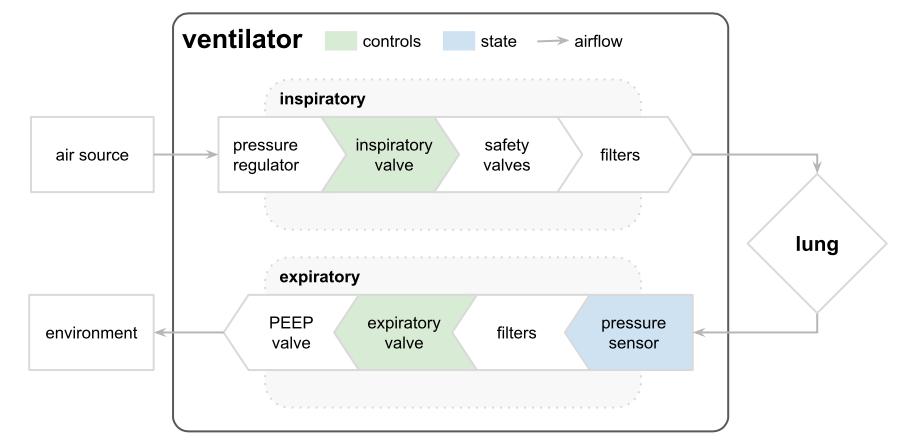</center><br>

When we read the csv file, we find information in eight columns, with the definitions below:

<center>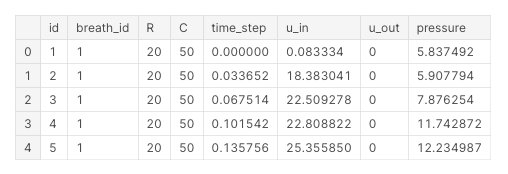</center><br>

<ul>
  <li>'id': globally-unique time step identifier across an entire file</li>
  <li>'breath_id': globally-unique time step for breaths</li>
  <li>'C': lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.</li>
  <li>'R':lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.</li>
  <li>'time_step': the actual time stamp.</li>
  <li>'u_in': the control input for the inspiratory solenoid valve. Ranges from 0 to 100.</li>
  <li>'u_out': the control input for the exploratory solenoid valve. Either 0 or 1.</li>
  <li>'pressure': the airway pressure measured in the respiratory circuit, measured in cmH2O.</li>
</ul>

## Histograms
Now, let's look closer to some of these columns and visualize the histograms. Although data type of 'C' and 'R' columns are numerical, the unique value number of there columns are 3. So it makes more sense to process these columns as categorical instead of numerical. As preprocessing, I applied one-hot encoding to 'C' and 'R' columns and robust scaling to 'u_in' column. 

<p float="left">
  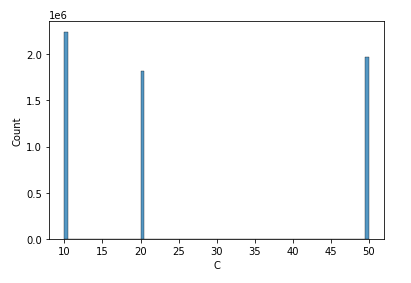
  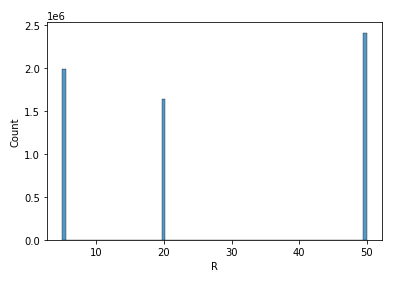
  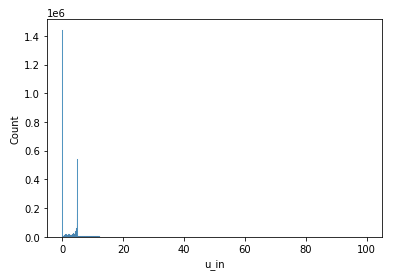
  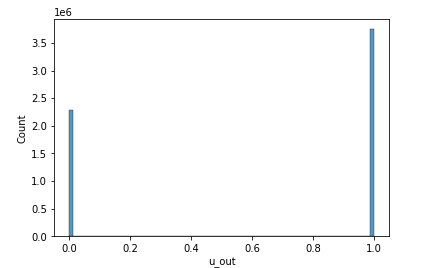
  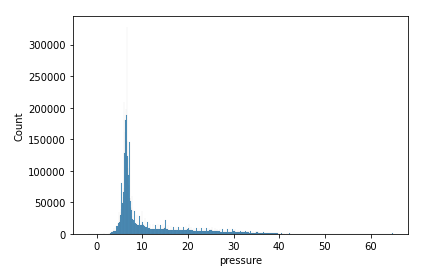
</p>

## Time series
In the dataset, each breath is represented by 'id' and each time step of each breath is represented by 'breath_id'. Let's see if there is a certain breath length or it differs. To visualize this, I grouped the dataset by 'id' column. You can see that all of them has the same length, 80 steps per each. 
<center>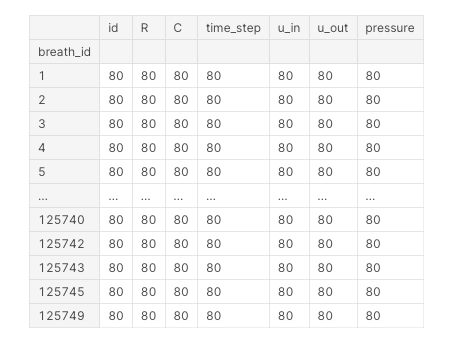</center><br>

## Model choice, training and results
This is a dataset with sequences so I prefered to used LSTM layers which are so powerfull to solve these kinds of problems. I also combined LSTM with bidirectional layer which wraps LSTM layer and trains two instead of one LSTMs; the first on the input sequence as it is and the second on a reversed copy of the input sequence. This provides additional context to the network and result in faster and even fuller learning on the problem.
As regularization technique to struggle with overfitting, batch normalization and dropout layers were used. This is not a classification but a regression problem so at the last dense layer, the activation function is 'linear' to make a numerical prediction instead of a probability. Because of the same reason, our metric is 'mean squared error' which is a common regression metric.

After training 200 epochs, train loss decreased to 0.162 and validation loss decreased to 0.239.

<p float="left">
    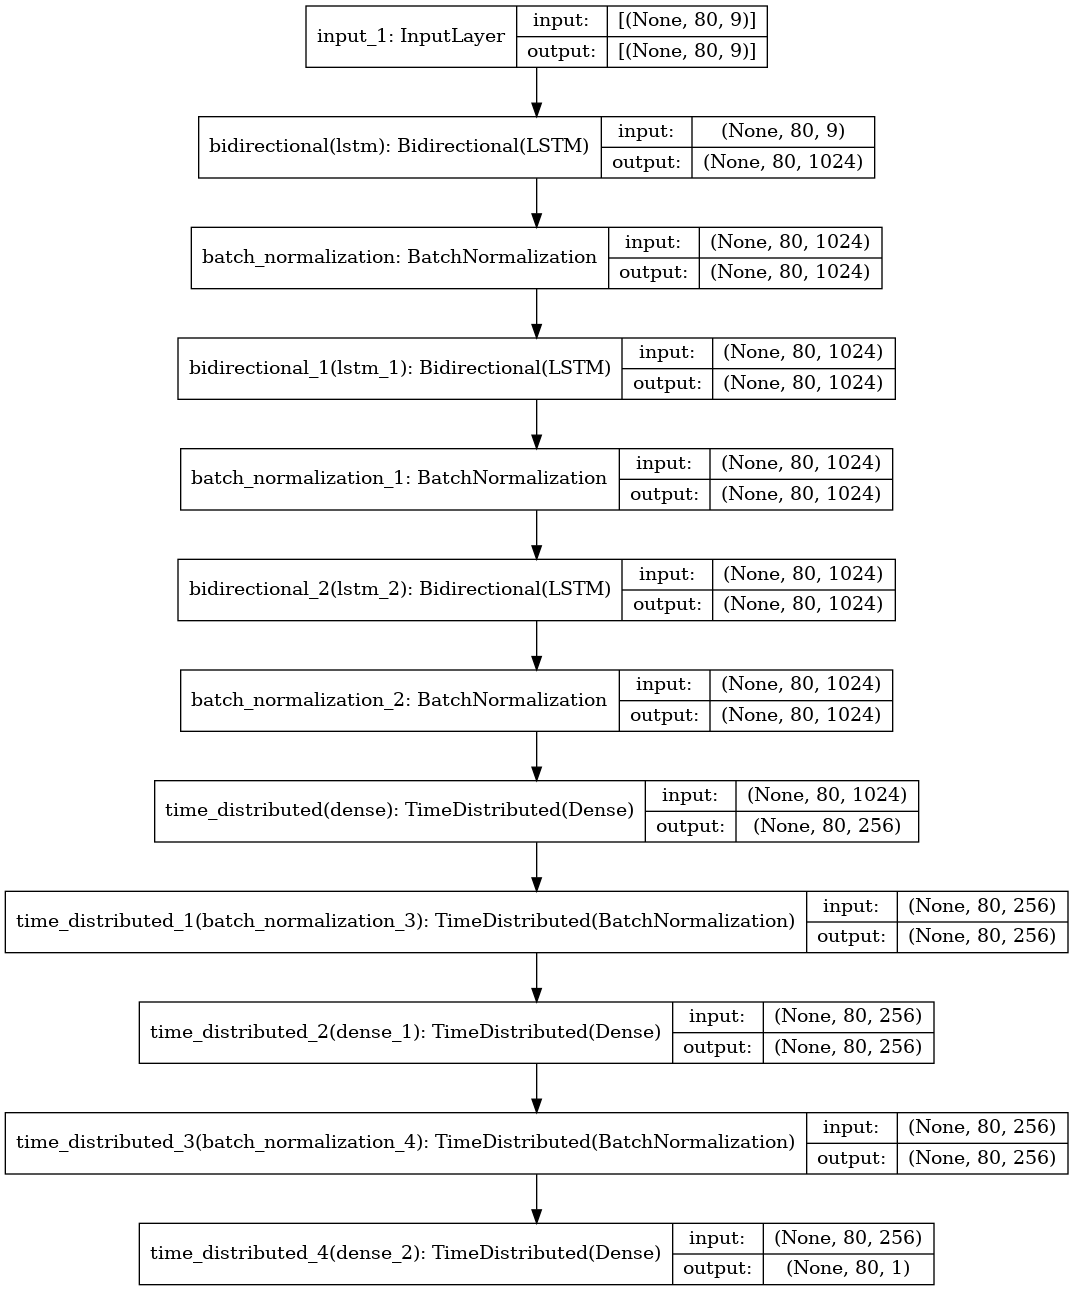
    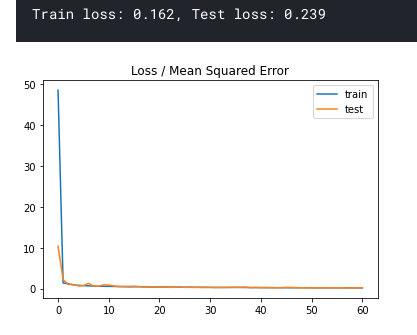
</p>

[1]: https://www.kaggle.com/c/ventilator-pressure-prediction/overview

## After this sumary, let's see how I obtained these results

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Bidirectional, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model



In [2]:
train_dir = '/kaggle/input/ventilator-pressure-prediction/train.csv'
test_dir = '/kaggle/input/ventilator-pressure-prediction/test.csv'


In [3]:
train_df= pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

In [4]:
train_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [5]:
# the features I want to use and analyse
train_features = pd.DataFrame(np.copy(train_df[['breath_id', 'time_step', 'R', 'C', 'u_in', 'u_out']]), columns = ['breath_id', 'time_step', 'R', 'C', 'u_in', 'u_out'])
# the features I want to use and analyse
Y = pd.DataFrame(np.copy(train_df['pressure']), columns = ['pressure'])

In [6]:
train_features.head()

,breath_id,time_step,R,C,u_in,u_out
0,1.0,0.000000,20.0,50.0,0.083334,0.0
1,1.0,0.033652,20.0,50.0,18.383041,0.0
2,1.0,0.067514,20.0,50.0,22.509278,0.0
3,1.0,0.101542,20.0,50.0,22.808822,0.0
4,1.0,0.135756,20.0,50.0,25.355850,0.0


<AxesSubplot:xlabel='R', ylabel='Count'>

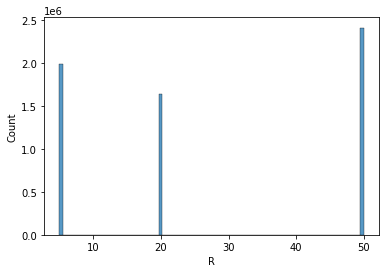

In [7]:
sns.histplot(data=train_features['R'])

<AxesSubplot:xlabel='C', ylabel='Count'>

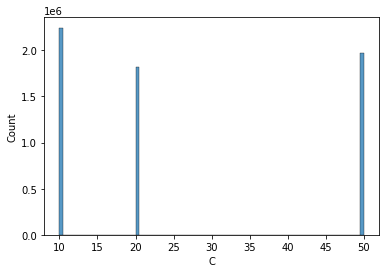

In [8]:
sns.histplot(data=train_features['C'])


<AxesSubplot:xlabel='u_in', ylabel='Count'>

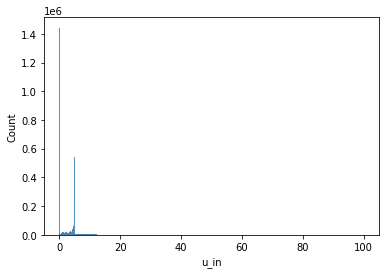

In [9]:
sns.histplot(data=train_features['u_in'])


<AxesSubplot:xlabel='u_out', ylabel='Count'>

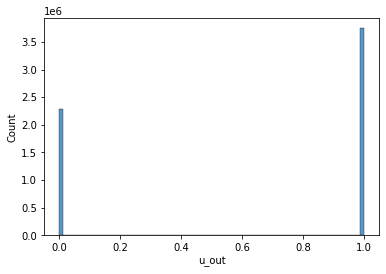

In [10]:
sns.histplot(data=train_features['u_out'])

<AxesSubplot:xlabel='pressure', ylabel='Count'>

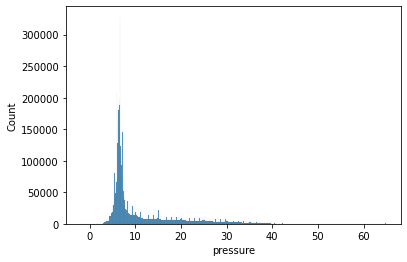

In [11]:
sns.histplot(data=Y['pressure'])

In [12]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  float64
 1   time_step  float64
 2   R          float64
 3   C          float64
 4   u_in       float64
 5   u_out      float64
dtypes: float64(6)
memory usage: 276.3 MB


In [13]:
train_features.describe()

,breath_id,time_step,R,C,u_in,u_out
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,1.307225e+00,2.703618e+01,2.608072e+01,7.321615e+00,6.204493e-01
std,3.633526e+04,7.659778e-01,1.959549e+01,1.715231e+01,1.343470e+01,4.852752e-01
min,1.000000e+00,0.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00
25%,3.137700e+04,6.428995e-01,5.000000e+00,1.000000e+01,3.936623e-01,0.000000e+00
50%,6.276550e+04,1.308123e+00,2.000000e+01,2.000000e+01,4.386146e+00,1.000000e+00
75%,9.430100e+04,1.965502e+00,5.000000e+01,5.000000e+01,4.983895e+00,1.000000e+00
max,1.257490e+05,2.937238e+00,5.000000e+01,5.000000e+01,1.000000e+02,1.000000e+00


In [14]:
#Transform the observations to have a specific scale. 

In [15]:
# 'R' and  'C' features are categorical, needs one hot encoding
train_features = pd.get_dummies(train_features, columns = ['R', 'C'], prefix = ['R', 'C'])

In [16]:
train_features.head()

,breath_id,time_step,u_in,u_out,R_5.0,R_20.0,R_50.0,C_10.0,C_20.0,C_50.0
0,1.0,0.000000,0.083334,0.0,0,1,0,0,0,1
1,1.0,0.033652,18.383041,0.0,0,1,0,0,0,1
2,1.0,0.067514,22.509278,0.0,0,1,0,0,0,1
3,1.0,0.101542,22.808822,0.0,0,1,0,0,0,1
4,1.0,0.135756,25.355850,0.0,0,1,0,0,0,1


In [17]:
# Is there any difference in sequence lengths of unique breath IDs in test and train set?
print('seq lenghths of train set:')
train_df.groupby(["breath_id"]).count()

seq lenghths of train set:


,id,R,C,time_step,u_in,u_out,pressure
breath_id,,,,,,,
1,80,80,80,80,80,80,80
2,80,80,80,80,80,80,80
3,80,80,80,80,80,80,80
4,80,80,80,80,80,80,80
5,80,80,80,80,80,80,80
...,...,...,...,...,...,...,...
125740,80,80,80,80,80,80,80
125742,80,80,80,80,80,80,80
125743,80,80,80,80,80,80,80


In [18]:
print('seq lenghths of test set:')
test_df.groupby(["breath_id"]).count()

seq lenghths of test set:


,id,R,C,time_step,u_in,u_out
breath_id,,,,,,
0,80,80,80,80,80,80
8,80,80,80,80,80,80
11,80,80,80,80,80,80
24,80,80,80,80,80,80
31,80,80,80,80,80,80
...,...,...,...,...,...,...
125741,80,80,80,80,80,80
125744,80,80,80,80,80,80
125746,80,80,80,80,80,80


In [19]:
# convert to tensor
tensor = np.array(train_features).reshape((int(len(train_features)/80), 80, 10))
# drop 'breath_id'
X = tensor[:,:,1:]
Y = np.array(Y).reshape((int(len(Y)/80), 80))

In [20]:
# Standardization of time series
# Transform the time series by getting the difference with the previous time step to remove the increasing trend in the data.
def time_steps_diff(X):
    for i in range(len(X)):
        sample = X[i,:,:]
        time_steps = sample[1:,0] - sample[:-1,0]
        time_steps = np.insert(time_steps,0,0)
        X[i,:,0] = time_steps 
    return X

In [21]:
X = time_steps_diff(X)

In [22]:
# 'u_in' feature is numerical so needs scaling

def robust_scaler(X):
    scaler = RobustScaler()
    u_in = X[:,:,1].reshape(len(X)*80,1)
    u_in_scaled = scaler.fit_transform(u_in)
    u_in_scaled = u_in_scaled.reshape(int(len(u_in)/80), 80)
    X[:,:,1] = u_in_scaled
    return X

In [23]:
# before using scaler, the dataset should be split in train/val/test sets to avoid data leakage
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=7, shuffle=True)
X_val, X_testval, y_val, y_testval = train_test_split(X_val, y_val, test_size = 0.5, random_state=7, shuffle=True)


In [24]:
X_train = robust_scaler(X_train)
X_val = robust_scaler(X_val)
X_testval = robust_scaler(X_testval)

In [25]:
def model():
    model = Sequential()
    model.add(Input(shape=(80, 9)))
    model.add(Bidirectional(LSTM(filter_size, input_shape=(80, 9), return_sequences=True)))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(filter_size, return_sequences=True)))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(filter_size, return_sequences=True)))
    model.add(BatchNormalization())
    
    model.add(TimeDistributed(Dense(filter_size/2, activation="relu")))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dense(filter_size/2, activation="relu")))
    model.add(TimeDistributed(BatchNormalization()))
    
    model.add(TimeDistributed(Dense(1, activation = "linear")))

    return model

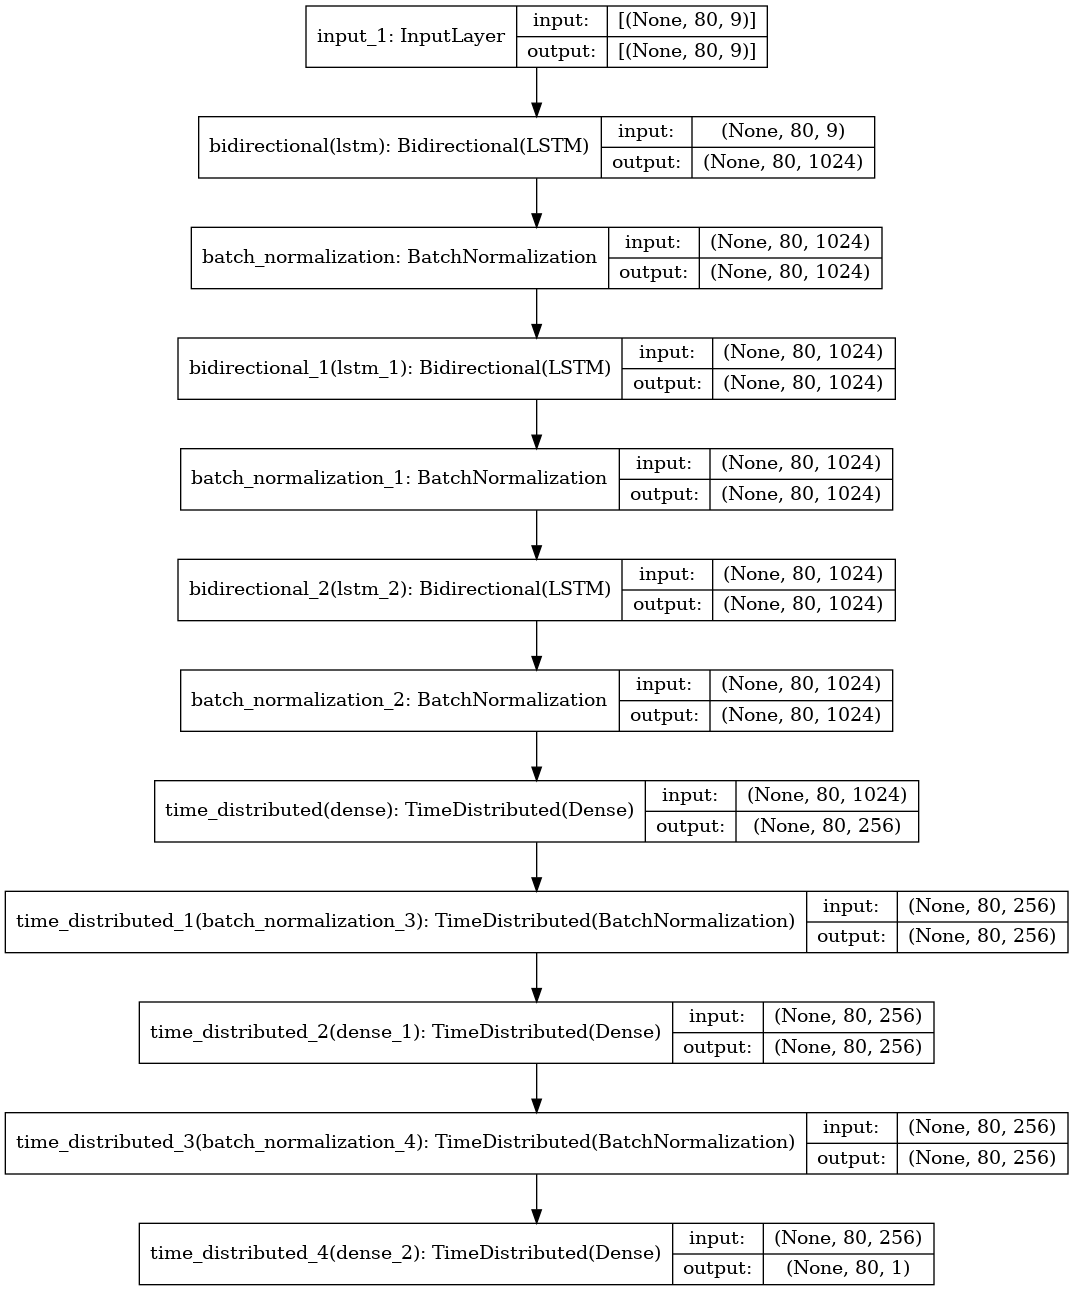

In [27]:
tf.keras.utils.plot_model(model, to_file="plot_model.png", show_shapes=True)

In [26]:
initial_learning_rate = 0.001
filter_size = 512
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = initial_learning_rate,
        decay_steps = 100000,
        decay_rate = 0.96,
        staircase = True)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
    
opt  = tf.keras.optimizers.Adam(learning_rate=lr_schedule )
model = model()
model.compile(loss='mean_squared_error', optimizer = opt)
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 80, 1024)          2138112   
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 1024)          4096      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 1024)          6295552   
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 1024)          4096      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 1024)          6295552   
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 1024)          4096      
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 256)           2

In [ ]:
# training
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=200, batch_size = 256, callbacks = [callback], shuffle=True, verbose = 1)

In [ ]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_testval, y_testval, verbose=0)
print('Train loss: %.3f, Test loss: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# preprocessing of test data
test_features = pd.DataFrame(np.copy(test_df[['breath_id', 'time_step', 'R', 'C', 'u_in', 'u_out']]), columns = ['breath_id', 'time_step', 'R', 'C', 'u_in', 'u_out'])
submission = pd.DataFrame(np.copy(test_df['id']), columns = ['id'])
test_features = pd.get_dummies(test_features, columns = ['R', 'C'], prefix = ['R', 'C'])
test_tensor = np.array(test_features).reshape((int(len(test_features)/80), 80, 10))
test_X = test_tensor[:,:,1:]
test_X = time_steps_diff(test_X)
test_X = robust_scaler(test_X)

# prediction
y_pred = model.predict(test_X)
y_pred = y_pred.reshape((len(y_pred)*80,1))
submission['pressure'] = y_pred
submission

In [ ]:
pd.DataFrame(submission).to_csv("submission.csv", index=False)

In [ ]:
path = '/kaggle/working/model/'
model.save(path)
np.save(path+'model.npy',history.history)